### INF-510, 2016, Claudio Torres, ctorres@inf.utfsm.cl. DI-UTFSM
#### Textbook: Lloyd N. Trefethen, Spectral Methods in MATLAB, SIAM, Philadelphia, 2000

# More on Spectral Matrices

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse.linalg as sp
from scipy import interpolate
import scipy as spf
from sympy import *
import sympy as sym
from scipy.linalg import toeplitz
from ipywidgets import interact
from ipywidgets import IntSlider
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from ipywidgets import interact
# The variable M is used for changing the default size of the figures
M=5

### Chebyshev differentiation matrix

In [2]:
def cheb(N):
    if N==0:
        D=0
        x=1
        return D,x
    x = np.cos(np.pi*np.arange(N+1)/N)
    c=np.hstack((2,np.ones(N-1),2))*((-1.)**np.arange(N+1))
    X=np.tile(x,(N+1,1)).T
    dX=X-X.T
    D = np.outer(c,1./c)/(dX+np.eye(N+1))
    D = D - np.diag(np.sum(D.T,axis=0))
    return D,x

## Understanding how the np.FFT does the FFT

v    : [  2.58819045e-01   5.00000000e-01   7.07106781e-01   8.66025404e-01
   9.65925826e-01   1.00000000e+00   9.65925826e-01   8.66025404e-01
   7.07106781e-01   5.00000000e-01   2.58819045e-01  -3.21624530e-16
  -2.58819045e-01  -5.00000000e-01  -7.07106781e-01  -8.66025404e-01
  -9.65925826e-01  -1.00000000e+00  -9.65925826e-01  -8.66025404e-01
  -7.07106781e-01  -5.00000000e-01  -2.58819045e-01  -2.44929360e-16]
vhat : [ -2.28739958e-15 +0.00000000e+00j   3.10582854e+00 -1.15911099e+01j
  -2.08161376e-15 -1.01869323e-16j  -8.10356016e-16 -5.57104273e-16j
  -4.49810399e-16 -4.90650061e-16j  -2.10942375e-15 +3.21964677e-15j
   3.88578059e-16 -1.14423775e-17j   9.99200722e-16 -5.55111512e-16j
   2.27765794e-16 +4.70831282e-16j  -3.17658781e-16 -4.16333634e-16j
  -1.38832292e-16 +9.04269456e-17j  -2.66453526e-15 +8.88178420e-16j
   4.00020436e-16 +0.00000000e+00j   4.44089210e-16 +8.88178420e-16j
  -1.38832292e-16 -9.04269456e-17j  -2.11689917e-16 +4.34125406e-16j
   2.27765794e-16 -

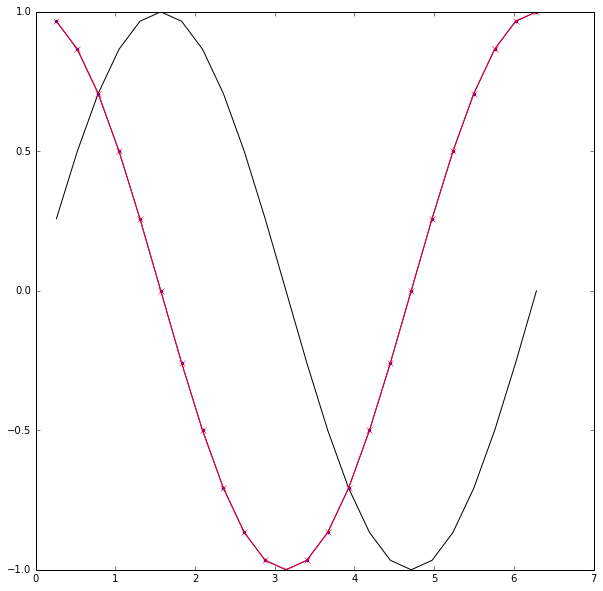

In [7]:
N=24
x=np.linspace(2*np.pi/N,2*np.pi,N)
v=np.sin(x)
K=np.fft.fftfreq(N)*N
iK=1j*K
vhat=np.fft.fft(v)
print('v    :',v)
print('vhat :',vhat)
print('K    :',K)

W=iK*vhat
W[int(N/2)]=0
print('W    :',W)

vp=np.real(np.fft.ifft(W))

print('vprime: ',vp)
plt.figure(figsize=(10,10))
plt.plot(x,v,'k')
plt.plot(x,np.cos(x),'b.-')
plt.plot(x,np.real(vp),'rx-')
plt.show()

In [8]:
def spectralDerivativeByFFT(v,nu=1):
    if not np.all(np.isreal(v)):
        raise ValueError('The input vector must be real')
    N=v.shape[0]
    K=np.fft.fftfreq(N)*N
    iK=(1j*K)**nu
    v_hat=np.fft.fft(v)
    w_hat=iK*v_hat
    if np.mod(nu,2)!=0:
        w_hat[int(N/2)]=0
    return np.real(np.fft.ifft(w_hat))

def my_D2_spec_2pi(N):
    h=(2*np.pi/N)
    c=np.zeros(N)
    j=np.arange(1,N)
    c[0]=-np.pi**2/(3.*h**2)-1./6.
    #print(c)
    c[1:]=-0.5*((-1)**j)/(np.sin(j*h/2.)**2)
    #print(c)
    D2=toeplitz(c)
    return D2

# Example 1: Computing Eigenvalues

We are solving: $-u''(x)+x^2\,u(x)=\lambda\, u(x)$ on $\mathbb{R}$

In [9]:
L=8.0
for N in np.arange(6,36+1,6):
    h=2*np.pi/N
    x=np.linspace(h,2*np.pi,N)
    x=L*(x-np.pi)/np.pi
    D2=(np.pi/L)**2*my_D2_spec_2pi(N)
    eigenvalues = np.sort(np.linalg.eigvals(-D2+np.diag(x**2)))
    print('N: ',N)
    print(eigenvalues[:4])

N:  6
[  0.46147292   7.49413462   7.72091605  28.83248378]
N:  12
[ 0.97813728  3.17160532  4.45593529  8.92452906]
N:  18
[ 0.99997     3.00064407  4.99259532  7.0395719 ]
N:  24
[ 1.          3.0000001   4.99999797  7.000025  ]
N:  30
[ 1.  3.  5.  7.]
N:  36
[ 1.  3.  5.  7.]


# Example 2:  Solving ODE

Solving the following BVP $u_{xx}=\exp(4\,x)$ with $u(-1)=u(1)=0$

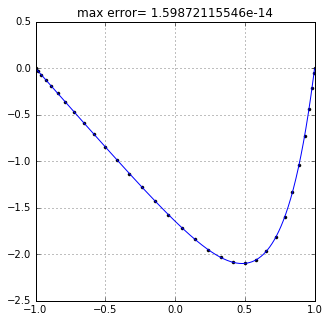

In [10]:
def example_2(N=16):
    D,x = cheb(N)
    D2  = np.dot(D,D)
    D2  = D2[1:-1,1:-1]
    f   = np.exp(4*x[1:-1])
    u   = np.linalg.solve(D2,f)
    u   = np.concatenate(([0],u,[0]),axis=0)

    plt.figure(figsize=(M,M))
    plt.plot(x,u,'k.')
    xx  = np.linspace(-1,1,1000)
    P   = np.polyfit(x, u, N)
    uu  = np.polyval(P, xx)
    plt.plot(xx,uu,'b-')
    plt.grid(True)
    exact = (np.exp(4*xx)-np.sinh(4.)*xx-np.cosh(4.))/16.
    plt.title('max error= '+str(np.linalg.norm(exact-uu,np.inf)))
    plt.ylim([-2.5,0.5])
    plt.show()
interact(example_2,N=(2,35))

# Example 3: Solving ODE 

Solving the following BVP $u_{xx}=\exp(u)$ with $u(-1)=u(1)=0$

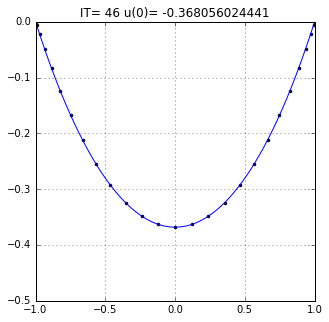

In [11]:
def example_3(N=16,IT=20):
    D,x = cheb(N)
    D2  = np.dot(D,D)
    D2  = D2[1:-1,1:-1]

    u   = np.zeros(N-1)
    for i in np.arange(IT):
        u_new = np.linalg.solve(D2,np.exp(u))
        change = np.linalg.norm(u_new-u,np.inf)
        u = u_new

    u = np.concatenate(([0],u,[0]),axis=0)

    plt.figure(figsize=(M,M))
    plt.plot(x,u,'k.')
    xx  = np.linspace(-1,1,1000)
    P   = np.polyfit(x, u, N)
    uu  = np.polyval(P, xx)
    plt.plot(xx,uu,'b-')
    plt.grid(True)
    plt.title('IT= '+str(IT)+' u(0)= '+str(u[int(N/2)]))
    plt.ylim([-0.5,0.])
    plt.show()

interact(example_3,N=(2,30),IT=(0,100))

# Example 4: Eigenvalue BVP

Solve $u_{xx}=\lambda\,u$ with $u(-1)=u(1)=0$

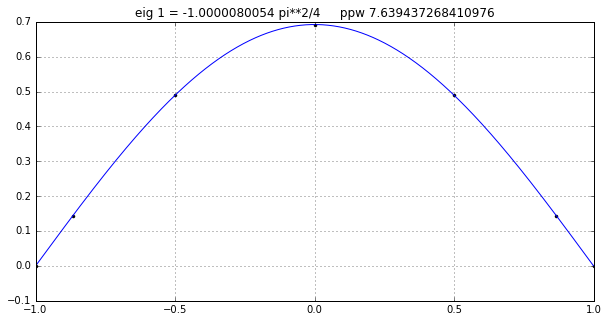

In [12]:
N_widget = IntSlider(min=2, max=50, step=1, value=36)
j_widget = IntSlider(min=1, max=49, step=1, value=5)

def update_j_range(*args):
    j_widget.max = N_widget.value-1
j_widget.observe(update_j_range, 'value')

def example_4(N=36,j=5):
    D,x = cheb(N)
    D2  = np.dot(D,D)
    D2  = D2[1:-1,1:-1]

    lam, V = np.linalg.eig(D2)

    ii=np.argsort(-np.real(lam))

    lam=lam[ii]
    V=V[:,ii]

    u = np.concatenate(([0],V[:,j-1],[0]),axis=0)

    plt.figure(figsize=(2*M,M))
    plt.plot(x,u,'k.')
    xx  = np.linspace(-1,1,1000)
    P   = np.polyfit(x, u, N)
    uu  = np.polyval(P, xx)
    plt.plot(xx,uu,'b-')
    plt.grid(True)
    plt.title('eig '+str(j)+' = '+str(lam[j-1]*4./(np.pi**2))+' pi**2/4'+'     ppw '+str(4*N/(np.pi*j)))
    plt.show()
interact(example_4,N=N_widget,j=j_widget)

# Example 5:  (2D) Poisson equation $u_{xx}+u_{yy}=f$ with u=0 on $\partial\Gamma$

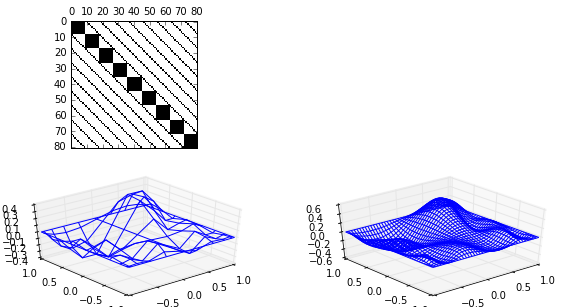

<function __main__.example_5>

In [14]:
elev_widget = IntSlider(min=0, max=180, step=10, value=40)
azim_widget = IntSlider(min=0, max=360, step=10, value=230)

def example_5(N=10,elev=40,azim=230):
    D,x = cheb(N)
    y=x
    D2  = np.dot(D,D)
    D2  = D2[1:-1,1:-1]

    xx,yy=np.meshgrid(x[1:-1],y[1:-1])
    xx = xx.flatten()
    yy = yy.flatten()

    f = 10*np.sin(8*xx*(yy-1))

    I = np.eye(N-1)
    # The Laplacian
    L = np.kron(I,D2)+np.kron(D2,I)

    u = np.linalg.solve(L,f)

    fig = plt.figure(figsize=(2*M,M))

    # The spy of the Laplacian
    plt.subplot(221)
    plt.spy(L)

    # Plotting the approximation and its interpolation

    # The numerical approximation
    uu = np.zeros((N+1,N+1))
    uu[1:-1,1:-1]=np.reshape(u,(N-1,N-1))
    xx,yy=np.meshgrid(x,y)
    value = uu[int(N/4),int(N/4)]

    plt.subplot(223,projection='3d')
    ax = fig.gca()
    #surf = ax.plot_surface(xxx, yyy, uuu_n, rstride=1, cstride=1, cmap=cm.coolwarm,
    #                       linewidth=0, antialiased=False)
    ax.plot_wireframe(xx, yy, uu)
    ax.view_init(elev,azim)

    # The INTERPOLATED approximation

    N_fine=4*N
    finer_mesh=np.linspace(-1,1,N_fine)
    xxx,yyy=np.meshgrid(finer_mesh,finer_mesh)
    uuu = spf.interpolate.interp2d(xx, yy, uu, kind='cubic')
    uuu_n=np.reshape(uuu(finer_mesh,finer_mesh),(N_fine,N_fine))

    plt.subplot(224,projection='3d')
    ax = fig.gca()
    #surf = ax.plot_surface(xxx, yyy, uuu_n, rstride=1, cstride=1, cmap=cm.coolwarm,
    #                       linewidth=0, antialiased=False)
    ax.plot_wireframe(xxx, yyy, uuu_n)
    ax.view_init(elev,azim)
    plt.show()
interact(example_5,N=(3,20),elev=elev_widget,azim=azim_widget)

# Example 6:  (2D) Helmholtz equation $u_{xx}+u_{yy}+k^2\,u=f$ with u=0 on $\partial\Gamma$

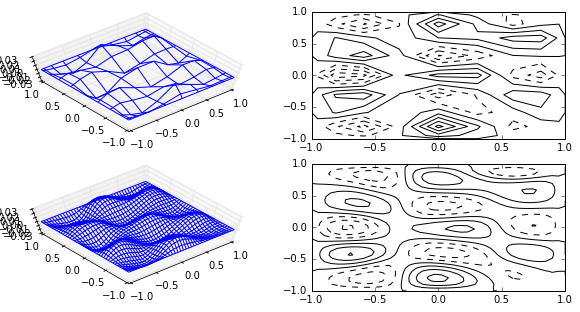

In [15]:
elev_widget = IntSlider(min=0, max=180, step=10, value=40)
azim_widget = IntSlider(min=0, max=360, step=10, value=230)

def example_6(N=10,elev=40,azim=230,k=9,n_contours=8):
    D,x = cheb(N)
    y=x
    D2  = np.dot(D,D)
    D2  = D2[1:-1,1:-1]

    xx,yy=np.meshgrid(x[1:-1],y[1:-1])
    xx = xx.flatten()
    yy = yy.flatten()

    f = np.exp(-10.*((yy-1.)**2+(xx-.5)**2))

    I = np.eye(N-1)
    # The Laplacian
    L = np.kron(I,D2)+np.kron(D2,I)+k**2*np.eye((N-1)**2)

    u = np.linalg.solve(L,f)

    fig = plt.figure(figsize=(2*M,M))

    # Plotting the approximation and its interpolation

    # The numerical approximation
    uu = np.zeros((N+1,N+1))
    uu[1:-1,1:-1]=np.reshape(u,(N-1,N-1))
    xx,yy=np.meshgrid(x,y)
    value = uu[int(N/4),int(N/4)]

    plt.subplot(221,projection='3d')
    ax = fig.gca()
    #surf = ax.plot_surface(xxx, yyy, uuu_n, rstride=1, cstride=1, cmap=cm.coolwarm,
    #                       linewidth=0, antialiased=False)
    ax.plot_wireframe(xx, yy, uu)
    ax.view_init(elev,azim)

    plt.subplot(222)
    plt.contour(xx, yy, uu, n_contours,
                 colors='k',  # negative contours will be dashed by default
                 )
   
    # The INTERPOLATED approximation
    N_fine=4*N
    finer_mesh=np.linspace(-1,1,N_fine)
    xxx,yyy=np.meshgrid(finer_mesh,finer_mesh)
    uuu = spf.interpolate.interp2d(xx, yy, uu, kind='cubic')
    uuu_n=np.reshape(uuu(finer_mesh,finer_mesh),(N_fine,N_fine))

    plt.subplot(223,projection='3d')
    ax = fig.gca()
    #surf = ax.plot_surface(xxx, yyy, uuu_n, rstride=1, cstride=1, cmap=cm.coolwarm,
    #                       linewidth=0, antialiased=False)
    ax.plot_wireframe(xxx, yyy, uuu_n)
    ax.view_init(elev,azim)
    
    plt.subplot(224)
    plt.contour(xxx, yyy, uuu_n, n_contours,
                 colors='k',  # negative contours will be dashed by default
                 )
    
    plt.show()
interact(example_6,N=(3,30),elev=elev_widget,azim=azim_widget,k=(1,20),n_contours=(5,12))

# Example 7:  (2D)  $-(u_{xx}+u_{yy})=\lambda\,u$ with u=0 on $\partial\Gamma$

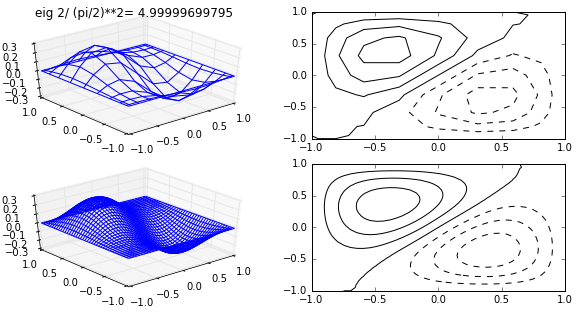

In [16]:
elev_widget = IntSlider(min=0, max=180, step=10, value=40)
azim_widget = IntSlider(min=0, max=360, step=10, value=230)
N_widget = IntSlider(min=2, max=30, step=1, value=10)
j_widget = IntSlider(min=1, max=20, step=1, value=1)

def update_j_range(*args):
    j_widget.max = (N_widget.value-1)**2
j_widget.observe(update_j_range, 'value')

def example_7(N=10,elev=40,azim=230,n_contours=8,j=1):
    D,x = cheb(N)
    y=x
    D2  = np.dot(D,D)
    D2  = D2[1:-1,1:-1]

    xx,yy=np.meshgrid(x[1:-1],y[1:-1])
    xx = xx.flatten()
    yy = yy.flatten()

    I = np.eye(N-1)
    # The Laplacian
    L = (np.kron(I,-D2)+np.kron(-D2,I))

    lam, V = np.linalg.eig(L)

    ii=np.argsort(np.real(lam))
    lam=lam[ii]
    V=V[:,ii]

    fig = plt.figure(figsize=(2*M,M))

    # Plotting the approximation and its interpolation

    # The numerical approximation
    vv = np.zeros((N+1,N+1))
    vv[1:-1,1:-1]=np.reshape(np.real(V[:,j-1]),(N-1,N-1))
    xx,yy=np.meshgrid(x,y)

    plt.subplot(221,projection='3d')
    ax = fig.gca()
    #surf = ax.plot_surface(xxx, yyy, uuu_n, rstride=1, cstride=1, cmap=cm.coolwarm,
    #                       linewidth=0, antialiased=False)
    ax.plot_wireframe(xx, yy, vv)
    plt.title('eig '+str(j)+'/ (pi/2)**2= '+str(lam[j-1]/((np.pi/2)**2)))
    ax.view_init(elev,azim)

    plt.subplot(222)
    plt.contour(xx, yy, vv, n_contours,
                 colors='k',  # negative contours will be dashed by default
                 )

    # The INTERPOLATED approximation
    N_fine=4*N
    finer_mesh=np.linspace(-1,1,N_fine)
    xxx,yyy=np.meshgrid(finer_mesh,finer_mesh)
    vvv = spf.interpolate.interp2d(xx, yy, vv, kind='cubic')
    vvv_n=np.reshape(vvv(finer_mesh,finer_mesh),(N_fine,N_fine))

    plt.subplot(223,projection='3d')
    ax = fig.gca()
    #surf = ax.plot_surface(xxx, yyy, uuu_n, rstride=1, cstride=1, cmap=cm.coolwarm,
    #                       linewidth=0, antialiased=False)
    ax.plot_wireframe(xxx, yyy, vvv_n)
    ax.view_init(elev,azim)

    plt.subplot(224)
    plt.contour(xxx, yyy, vvv_n, n_contours,
                 colors='k',  # negative contours will be dashed by default
                 )

    plt.show()
interact(example_7,N=N_widget,elev=elev_widget,azim=azim_widget,n_contours=(5,12),j=j_widget)

# In-class work

## [Flash back] Implement Program 6, 7 and 12.

## [Today] Implement Program 19, 20, 21, 22 and 23.

### `Program 19`

In [13]:
def v0(x):
    return np.exp(-200.*x**2)

In [14]:
N = 80
D,x = cheb(N)

dt = 8./N**2
tmax = 4.
n_iter = int(tmax/dt)

V  = np.empty((n_iter+1, x.shape[0]))
V[0] = v0(x-dt)
V[1] = v0(x)

for i in range(1,n_iter):
    w = np.dot(D, np.dot(D, V[i])); w[0] = 0.; w[-1] = 0.
    V[i+1] = 2*V[i] - V[i-1] + (dt**2)*w

In [10]:
def plot_helper(t):
    v = V[t]
    plt.plot(x, v)
    plt.show() 

In [15]:
#interact(plot_helper, t=(0,3200))

In [16]:
t = np.linspace(0., tmax, V.shape[0])

<IPython.core.display.Javascript object>


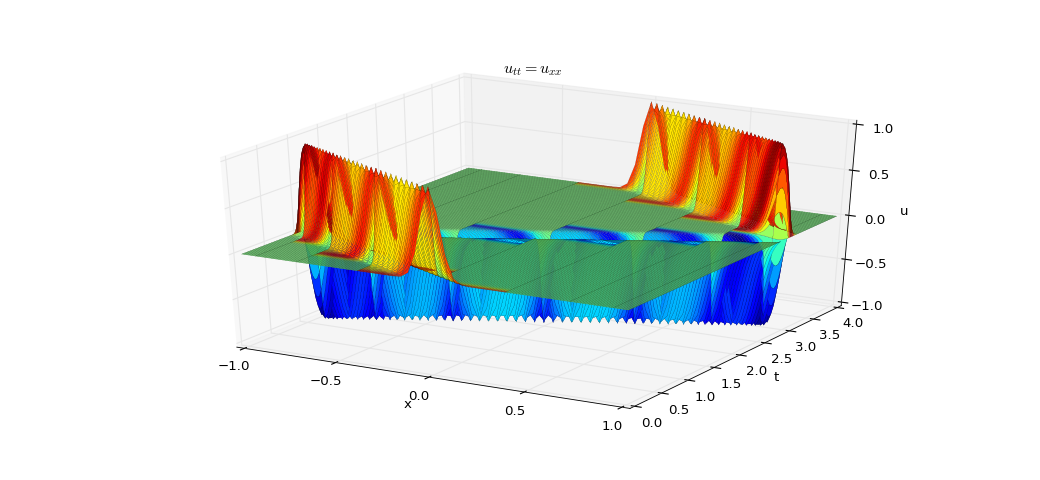

In [17]:
X , T = np.meshgrid(x, t, sparse=True)
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, V, linewidth=0.1, cmap='jet')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
plt.title('$u_{tt} = u_{xx}$')
plt.show()